In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)






 Data Loading


In [3]:

df = pd.read_csv("ecommerce_returns_dataset.csv")

# Quick look
print(df.head())
print(df.info())
print(df["Return"].value_counts())



  Product_Category   Price  Customer_Tenure_Months  Previous_Returns  \
0            Books  456.11                   116.0               9.0   
1      Electronics   47.63                     NaN               1.0   
2            Books  496.05                    39.0               8.0   
3             Home  478.78                    75.0               7.0   
4      Electronics  449.22                    39.0               0.0   

  Day_of_Week  Order_Hour Delivery_Speed  Return  
0         Sun        18.0      Expedited       1  
1         Tue         NaN       Standard       0  
2         Mon        14.0      Expedited       1  
3         Fri         4.0        SameDay       1  
4         Tue         NaN       Standard       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Product_Category        5000 non-null   obje


 Data Cleaning / Missing Values

 Fill numeric missing values with median

 Check missing values

In [4]:

num_cols = ["Price", "Customer_Tenure_Months", "Previous_Returns", "Order_Hour"]
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)


print(df.isnull().sum())



Product_Category          0
Price                     0
Customer_Tenure_Months    0
Previous_Returns          0
Day_of_Week               0
Order_Hour                0
Delivery_Speed            0
Return                    0
dtype: int64


C:\Users\nitik\AppData\Local\Temp\ipykernel_30664\1400701298.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\nitik\AppData\Local\Temp\ipykernel_30664\1400701298.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Target Distribution Visualization

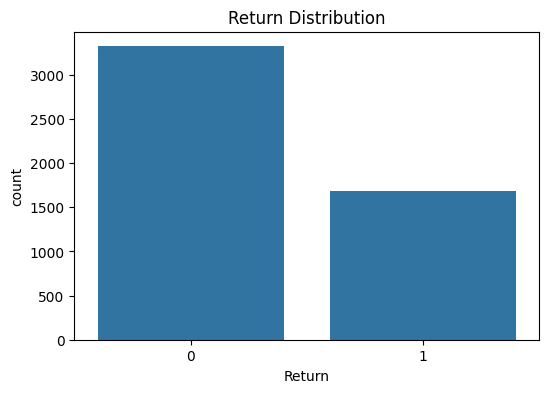

In [5]:



plt.figure(figsize=(6,4))
sns.countplot(x="Return", data=df)
plt.title("Return Distribution")
plt.show()




Feature Encoding

In [6]:


X = df.drop(columns="Return")
y = df["Return"]

cat_cols = X.select_dtypes(include="object").columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)



Train/Test Split and Scaling numeric features

In [7]:



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)




scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Visualizations: Correlation and Price Distribution

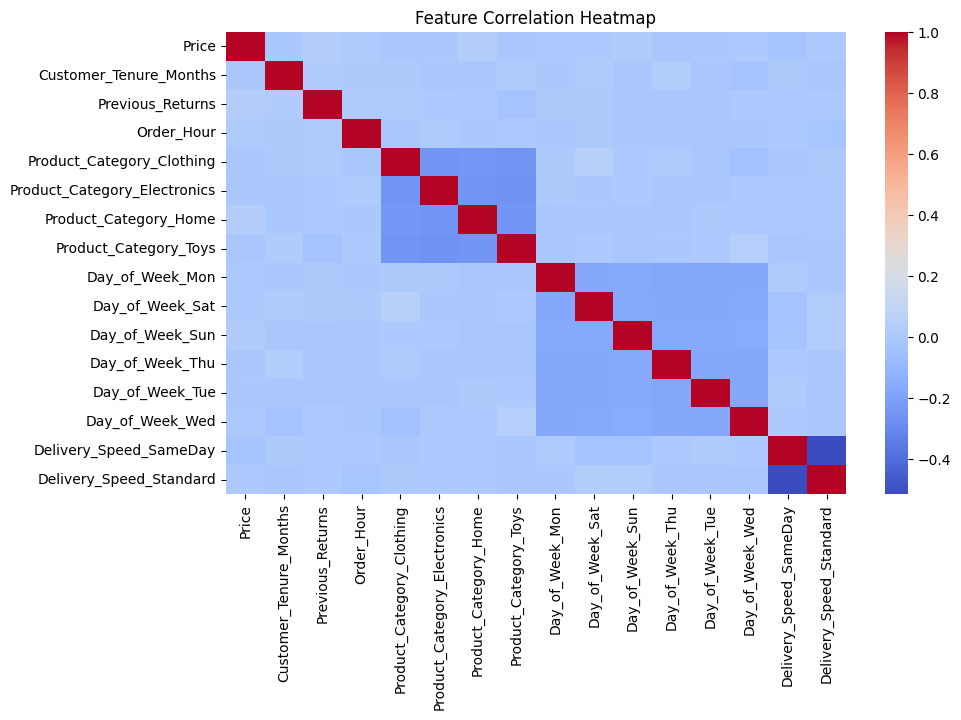

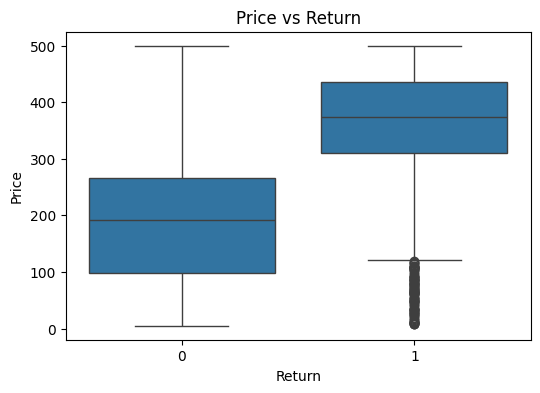

In [8]:



plt.figure(figsize=(10,6))
sns.heatmap(pd.DataFrame(X_train, columns=X.columns).corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=df["Price"])
plt.title("Price vs Return")
plt.show()



Model Evaluation Function


In [9]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("PR-AUC :", average_precision_score(y_test, y_proba))




Model Training

In [10]:



from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

comparison_df = pd.DataFrame(results).sort_values(by="Recall", ascending=False)
print("\nModel Comparison (sorted by Recall):\n", comparison_df)

best_model_name = comparison_df.iloc[0]["Model"]
print("\nBest model based on recall:", best_model_name)


Model Comparison (sorted by Recall):
            Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
3  Random Forest    0.9864   0.983213  0.976190  0.979689  0.995555
0            SVM    0.9192   0.905852  0.847619  0.875769  0.970962
1    Naive Bayes    0.8288   0.762755  0.711905  0.736453  0.903864
2            KNN    0.8480   0.830460  0.688095  0.752604  0.894834

Best model based on recall: Random Forest


Feature Importance (Random Forest)


Top 10 Important Features:
 Price                           0.472338
Previous_Returns                0.204953
Customer_Tenure_Months          0.096303
Product_Category_Clothing       0.079752
Delivery_Speed_SameDay          0.059415
Order_Hour                      0.033450
Delivery_Speed_Standard         0.012212
Product_Category_Electronics    0.007198
Product_Category_Toys           0.006299
Product_Category_Home           0.006067
dtype: float64


C:\Users\nitik\AppData\Local\Temp\ipykernel_30664\1558766612.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette="magma")


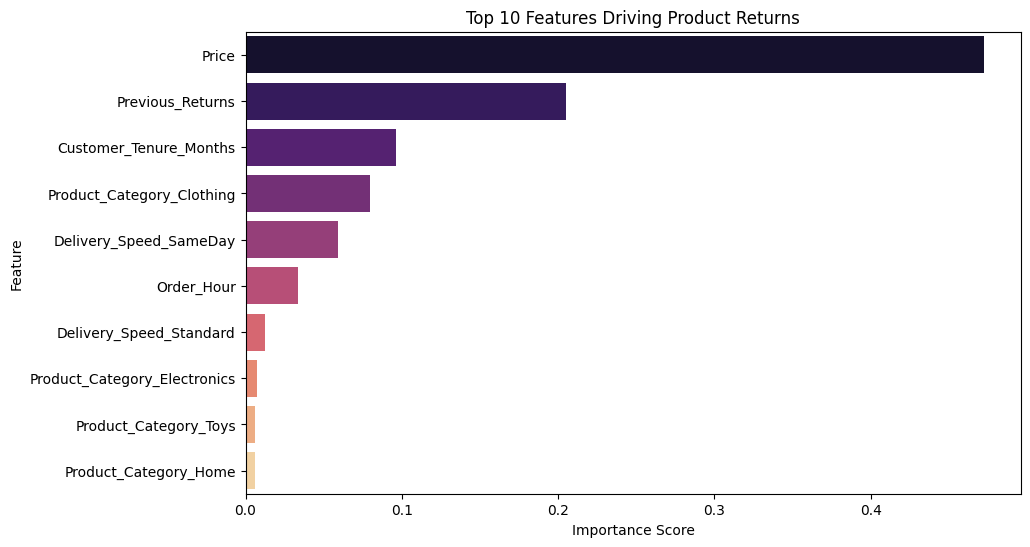

In [11]:



rf_model = models["Random Forest"]
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 Important Features:\n", importances.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette="magma")
plt.title("Top 10 Features Driving Product Returns")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
